In [1]:
import pandas as pd
import numpy as np 

In [2]:
b = pd.read_csv('bki.csv')
b_balance = pd.read_csv('bki_balance.csv')
csh_p_balance = pd.read_csv('cash_pos_balance.csv')
cr_cd_balance = pd.read_csv('credit_card_balance.csv')
inst_pmts = pd.read_csv('installments_payments.csv')
prv_ln = pd.read_csv('previous_loan.csv')
train = pd.read_csv('train.csv')
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import random

In [4]:
from functools import reduce

In [5]:
from sklearn. model_selection import train_test_split

#### Для презентации

In [6]:
train['target'].value_counts(normalize=True)

target
0    0.919238
1    0.080762
Name: proportion, dtype: float64

In [7]:
train['contract_type_name'].value_counts(normalize=True)

contract_type_name
Cash loans         0.904631
Revolving loans    0.095369
Name: proportion, dtype: float64

C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\301459836.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cash_loans = train['contract_type_name'].value_counts()[0]
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\301459836.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  credit_cards = train['contract_type_name'].value_counts()[1]


([<matplotlib.patches.Wedge at 0x1f0c5c57b90>,
 [Text(-1.0509963728306637, 0.32466386355242693, 'cash_loans'),
  Text(1.05099635763205, -0.32466391275311773, 'credit_cards')])

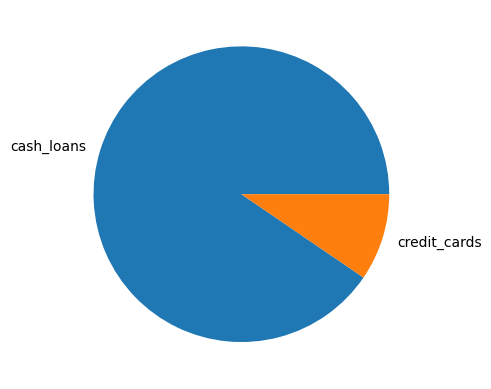

In [8]:
cash_loans = train['contract_type_name'].value_counts()[0]
credit_cards = train['contract_type_name'].value_counts()[1] 
values = [cash_loans, credit_cards]
names = ['cash_loans', 'credit_cards']
plt.pie(values, labels=names)

#### переменные из тг

##### Список из переменных для мержда

In [9]:
variables = []

##### лимит по активным кредитам (= credit_sum) (макс, мин, сумма)

In [10]:
b_a = b[b['credit_status'] == 'Active']
active_credits_limit_max = b_a.groupby('reco_id_curr')['credit_sum_limit'].max()
active_credits_limit_max.name = 'active_credits_limit_max'
active_credits_limit_min = b_a.groupby('reco_id_curr')['credit_sum_limit'].min()
active_credits_limit_min.name = 'active_credits_limit_min'
active_credits_limit_sum = b_a.groupby('reco_id_curr')['credit_sum_limit'].sum()
active_credits_limit_sum.name = 'active_credits_limit_sum'
variables.append(active_credits_limit_max)
variables.append(active_credits_limit_min)
variables.append(active_credits_limit_sum)
variables

[reco_id_curr
 100001         0.000
 100002     31988.565
 100003    810000.000
 100005         0.000
 100008         0.000
              ...    
 456247         0.000
 456249         0.000
 456250     58268.385
 456253         0.000
 456255         0.000
 Name: active_credits_limit_max, Length: 251815, dtype: float64,
 reco_id_curr
 100001         0.0
 100002         0.0
 100003    810000.0
 100005         0.0
 100008         0.0
             ...   
 456247         0.0
 456249         0.0
 456250         0.0
 456253         0.0
 456255         0.0
 Name: active_credits_limit_min, Length: 251815, dtype: float64,
 reco_id_curr
 100001         0.000
 100002     31988.565
 100003    810000.000
 100005         0.000
 100008         0.000
              ...    
 456247         0.000
 456249         0.000
 456250     58268.385
 456253         0.000
 456255         0.000
 Name: active_credits_limit_sum, Length: 251815, dtype: float64]

##### лимит по всем кредитам (макс, мин, сумма)

In [11]:
print(len(variables))
credits_limit_max = b.groupby('reco_id_curr')['credit_sum_limit'].max()
credits_limit_max.name = 'credits_limit_max'
credits_limit_min = b.groupby('reco_id_curr')['credit_sum_limit'].min()
credits_limit_min.name = 'credits_limit_min'
credits_limit_sum = b.groupby('reco_id_curr')['credit_sum_limit'].sum()
credits_limit_sum.name = 'credits_limit_sum'
variables.append(credits_limit_max)
variables.append(credits_limit_min)
variables.append(credits_limit_sum)
print(len(variables))

3
6


##### Задолженность по активным кредитам (макс, мин, сумма)

In [12]:
print(len(variables))
b_a = b[b['credit_status'] == 'Active']
active_credit_sum_debt_sum = b_a.groupby('reco_id_curr')['credit_sum_debt'].sum()
active_credit_sum_debt_sum.name = 'active_credit_sum_debt_sum'
active_credit_sum_debt_max = b_a.groupby('reco_id_curr')['credit_sum_debt'].max()
active_credit_sum_debt_max.name = 'active_credit_sum_debt_max'
active_credit_sum_debt_min = b_a.groupby('reco_id_curr')['credit_sum_debt'].min()
active_credit_sum_debt_min.name = 'active_credit_sum_debt_min'
variables.append(active_credit_sum_debt_sum)
variables.append(active_credit_sum_debt_max)
variables.append(active_credit_sum_debt_min)
print(len(variables))

6
9


##### Задолженность по всем кредитам (макс, мин, сумма)

In [13]:
print(len(variables))
total_credit_sum_debt_sum = b.groupby('reco_id_curr')['credit_sum_debt'].sum()
total_credit_sum_debt_sum.name = 'total_credit_sum_debt_sum'
total_credit_sum_debt_max = b.groupby('reco_id_curr')['credit_sum_debt'].max()
total_credit_sum_debt_max.name = 'total_credit_sum_debt_max'
total_credit_sum_debt_min = b.groupby('reco_id_curr')['credit_sum_debt'].min()
total_credit_sum_debt_min.name = 'total_credit_sum_debt_min'
variables.append(total_credit_sum_debt_sum)
variables.append(total_credit_sum_debt_max)
variables.append(total_credit_sum_debt_min)
print(len(variables))

9
12


#### bki

##### average_debt_curr

In [14]:
average_debt_curr = b.groupby('reco_id_curr')['credit_sum_debt'].agg('mean')
average_debt_curr.name = 'average_debt_curr'
variables.append(average_debt_curr)

##### total_debt_curr

In [15]:
total_debt_curr = b.groupby('reco_id_curr')['credit_sum_debt'].sum()
total_debt_curr.name = 'total_debt_curr'
variables.append(total_debt_curr)

##### active_credits

In [16]:
change_values = {'Active': 1, 'Closed': 0, 'Sold': 0, 'Bad debt': 0}
b_ac = b.copy(deep=True)
b_ac['credit_status'] = b_ac['credit_status'].map(change_values)
active_credits = b_ac.groupby('reco_id_curr')['credit_status'].sum()
active_credits.name = 'active_credits'
variables.append(active_credits)

##### closed_credits

In [17]:
change_values_2 = {'Active': 0, 'Closed': 1, 'Sold': 0, 'Bad debt': 0}
b_cc = b.copy(deep=True)
b_cc['credit_status'] = b_cc['credit_status'].map(change_values_2)
closed_credits = b_cc.groupby('reco_id_curr')['credit_status'].sum()
closed_credits.name = 'closed_credits'
variables.append(closed_credits)

##### recent_bad_debt

In [18]:
def bd_flag(x):
    if x != 0:
        return True
    else:
        return False

In [19]:
change_values_3 = {'Active': 0, 'Closed': 0, 'Sold': 0, 'Bad debt': 1}
b_bd = b.copy(deep=True)
b_bd['credit_status'] = b_bd['credit_status'].map(change_values_3)
bad_debt_flag = b_bd.groupby('reco_id_curr')['credit_status'].sum().apply(bd_flag)
bad_debt_flag.name = 'bad_debt_flag'
variables.append(bad_debt_flag)
print(bad_debt_flag)

reco_id_curr
100001    False
100002    False
100003    False
100004    False
100005    False
          ...  
456249    False
456250    False
456253    False
456254    False
456255    False
Name: bad_debt_flag, Length: 305811, dtype: bool


##### annuity_total


In [20]:
b_a = b.copy(deep=True)
annuity_total = b_a[b_a['credit_status'] == 'Active'].groupby('reco_id_curr')['annuity_payment'].sum()
annuity_total.name = 'annuity_total'
variables.append(annuity_total)

##### debt_creditsum_ratio

In [21]:
b_dcr = b.copy(deep=True)
b_dcr = b_dcr[b_dcr['credit_status'] == 'Active'].groupby('reco_id_curr')[['credit_sum', 'credit_sum_debt']].sum()
debt_creditsum_ratio = 1 - (b_dcr['credit_sum_debt'] / b_dcr['credit_sum'])
debt_creditsum_ratio.name = 'debt_creditsum_ratio'
variables.append(debt_creditsum_ratio)

In [22]:
print(variables)

[reco_id_curr
100001         0.000
100002     31988.565
100003    810000.000
100005         0.000
100008         0.000
             ...    
456247         0.000
456249         0.000
456250     58268.385
456253         0.000
456255         0.000
Name: active_credits_limit_max, Length: 251815, dtype: float64, reco_id_curr
100001         0.0
100002         0.0
100003    810000.0
100005         0.0
100008         0.0
            ...   
456247         0.0
456249         0.0
456250         0.0
456253         0.0
456255         0.0
Name: active_credits_limit_min, Length: 251815, dtype: float64, reco_id_curr
100001         0.000
100002     31988.565
100003    810000.000
100005         0.000
100008         0.000
             ...    
456247         0.000
456249         0.000
456250     58268.385
456253         0.000
456255         0.000
Name: active_credits_limit_sum, Length: 251815, dtype: float64, reco_id_curr
100001         0.000
100002     31988.565
100003    810000.000
100004         0.000


#### previous_loan

In [23]:
#минимальная сумма, запрошенная на кредит
loan_requested_min = prv_ln.groupby('reco_id_curr')['loan_body_requested'].min()
loan_requested_min.name = 'loan_requested_min'
variables.append(loan_requested_min)

In [24]:
#максимальная сумма, запрошенная на кредит
loan_requested_max = prv_ln.groupby('reco_id_curr')['loan_body_requested'].max()
loan_requested_max.name = 'loan_requested_max'
variables.append(loan_requested_max)

In [25]:
#максимальный аннуитетный платеж
annuity_payment_max = prv_ln.groupby('reco_id_curr')['annuity_payment'].max()
annuity_payment_max.name = 'annuity_payment_max'
variables.append(annuity_payment_max)

In [26]:
#минимальный аннуитетный платеж
annuity_payment_min = prv_ln.groupby('reco_id_curr')['annuity_payment'].min()
annuity_payment_min.name = 'annuity_payment_min'
variables.append(annuity_payment_min)

In [27]:
#максимальная одобренная сумма
loan_body_max = prv_ln.groupby('reco_id_curr')['loan_body'].max()
loan_body_max.name = 'loan_body_max'
variables.append(loan_body_max)

In [28]:
#суммарная одобренная сумма
loan_body_total = prv_ln.groupby('reco_id_curr')['loan_body'].sum()
loan_body_total.name = 'loan_body_total'
variables.append(loan_body_total)

In [29]:
#минимальная одобренная сумма
loan_body_min = prv_ln.groupby('reco_id_curr')['loan_body'].min()
loan_body_min.name = 'loan_body_min'
variables.append(loan_body_min)

In [30]:
#максимальный срок, на который оформлялся займ
payment_count_max = prv_ln.groupby('reco_id_curr')['payment_count'].max()
payment_count_max.name = 'payment_count_max'
variables.append(payment_count_max)

In [31]:
#минимальный срок, на который оформлялся займ
payment_count_min = prv_ln.groupby('reco_id_curr')['payment_count'].min()
payment_count_min.name = 'payment_count_min'
variables.append(payment_count_min)

#### inst_pmts

In [32]:
#максимальный первый взнос
first_payment_max = inst_pmts.groupby('reco_id_curr')['payment'].max()
first_payment_max.name = 'first_payment_max'
variables.append(first_payment_max)

In [33]:
#минимальный первый взнос
first_payment_min = inst_pmts.groupby('reco_id_curr')['payment'].min()
first_payment_min.name = 'first_payment_min'
variables.append(first_payment_min)

In [34]:
to_merge = pd.DataFrame()
for i in variables:
    to_merge = pd.concat([to_merge, i], axis=1)
to_merge

,active_credits_limit_max,active_credits_limit_min,active_credits_limit_sum,credits_limit_max,credits_limit_min,credits_limit_sum,active_credit_sum_debt_sum,active_credit_sum_debt_max,active_credit_sum_debt_min,total_credit_sum_debt_sum,...,loan_requested_max,annuity_payment_max,annuity_payment_min,loan_body_max,loan_body_total,loan_body_min,payment_count_max,payment_count_min,first_payment_max,first_payment_min
100001,0.000,0.0,0.000,0.000,0.0,0.000,596686.5,373239.0,110281.5,596686.5,...,24835.5,3951.000,3951.000,23787.0,23787.0,23787.0,8.0,8.0,17397.900,3951.000
100002,31988.565,0.0,31988.565,31988.565,0.0,31988.565,245781.0,245781.0,0.0,245781.0,...,179055.0,9251.775,9251.775,179055.0,179055.0,179055.0,24.0,24.0,53093.745,9251.775
100003,810000.000,810000.0,810000.000,810000.000,0.0,810000.000,0.0,0.0,0.0,0.0,...,900000.0,98356.995,6737.310,1035882.0,1452573.0,68053.5,12.0,6.0,560835.360,6662.970
100005,0.000,0.0,0.000,0.000,0.0,0.000,568408.5,543087.0,25321.5,568408.5,...,44617.5,4813.200,4813.200,40153.5,40153.5,0.0,12.0,12.0,17656.245,4813.200
100008,0.000,0.0,0.000,0.000,0.0,0.000,240057.0,240057.0,240057.0,240057.0,...,450000.0,25309.575,8019.090,501975.0,813838.5,0.0,30.0,6.0,432218.295,227.160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68715.000,130.500
451810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99900.000,33.705
452495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16591.500,14.805
454245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8098.065,8089.560


#### train_new_variables

##### testing train

In [35]:
train.head()

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,...,document_18_flag,document_19_flag,document_20_flag,document_21_flag,requests_bki_hour,requests_bki_day,requests_bki_week,requests_bki_month,requests_bki_qrt,requests_bki_year
0,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
1,214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
3,389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,4.0


In [36]:
train['years_birth'] = train['days_birth'] / (-1 * 365)
train['years_birth'].describe()

count    261384.000000
mean         43.929445
std          11.959221
min          20.517808
25%          33.991781
50%          43.134247
75%          53.923288
max          69.043836
Name: years_birth, dtype: float64

In [37]:
pd.crosstab(train['income_type_name'], train['years_birth'])

years_birth,20.517808,21.021918,21.030137,21.035616,21.038356,21.041096,21.043836,21.046575,21.049315,21.052055,...,68.986301,68.991781,68.997260,69.002740,69.016438,69.019178,69.027397,69.030137,69.032877,69.043836
income_type_name,,,,,,,,,,,,,,,,,,,,,
Businessman,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Commercial associate,1,1,2,0,1,1,2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Maternity leave,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pensioner,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,4,2,2
State servant,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
Student,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Unemployed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Working,0,0,0,3,0,3,0,1,2,1,...,0,0,0,0,0,1,0,0,0,0


In [38]:
train['social_circle_defaults_30_days'].describe()

count    260513.000000
mean          0.143217
std           0.443214
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: social_circle_defaults_30_days, dtype: float64

##### income_annuity_ratio

In [39]:
train['income_annuity_ratio'] = train['annuity_payment'] / train['income']
train['income_annuity_ratio']

0         0.254304
1         0.197764
2         0.193133
3         0.100764
4         0.141000
            ...   
261379    0.188200
261380    0.204133
261381    0.170933
261382    0.230657
261383    0.134680
Name: income_annuity_ratio, Length: 261384, dtype: float64

##### loan_income_ratio

In [40]:
train['loan_income_ratio'] = train['loan_body'] / train['income']
train['loan_income_ratio'].describe()

count    261384.000000
mean          3.959096
std           2.689901
min           0.004808
25%           2.018667
50%           3.267273
75%           5.161450
max          84.736842
Name: loan_income_ratio, dtype: float64

##### low_income_flag

In [41]:
def low_income(x):
    if x < train['income'].mean():
        return True
    else:
        return False

In [42]:
train['low_income_flag'] = train['income'].apply(low_income)
train['low_income_flag']

0         False
1         False
2         False
3         False
4          True
          ...  
261379     True
261380     True
261381     True
261382     True
261383     True
Name: low_income_flag, Length: 261384, dtype: bool

##### unreliable_income_flag

In [43]:
train['income_type_name'].unique()

array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
       'Student', 'Maternity leave', 'Businessman', 'Unemployed'],
      dtype=object)

In [44]:
good_income_types = ['Commercial associate', 'Working', 'Maternity leave', 'State servant', 'Businessman']
def unreliable_income(x):
    if x in good_income_types:
        return False
    else:
        return True

In [45]:
train['unreliable_income_flag'] = train['income_type_name'].apply(unreliable_income)

##### no_higher_education_flag

In [46]:
train['education_type_name'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Lower secondary', 'Incomplete higher', 'Academic degree'],
      dtype=object)

In [47]:
higher = ['Higher education', 'Academic degree']
def no_higher_education(x):
    if x in higher:
        return False
    else:
        return True

In [48]:
train['no_higher_education_flag'] = train['education_type_name'].apply(no_higher_education)
train['no_higher_education_flag']

0          True
1         False
2          True
3          True
4          True
          ...  
261379     True
261380     True
261381     True
261382     True
261383     True
Name: no_higher_education_flag, Length: 261384, dtype: bool

##### without_own_house_flag

In [49]:
train['housing_type_name'].unique()

array(['House / apartment', 'With parents', 'Municipal apartment',
       'Rented apartment', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [50]:
own = ['House / apartment', 'Municipal apartment']
def no_own_flat(x):
    if x in own:
        return False
    else:
        return True

In [51]:
train['without_own_house_flag'] = train['housing_type_name'].apply(no_own_flat)
train['without_own_house_flag']

0         False
1         False
2         False
3         False
4         False
          ...  
261379    False
261380     True
261381    False
261382    False
261383    False
Name: without_own_house_flag, Length: 261384, dtype: bool

##### young_client_flag

In [52]:
def too_young(x):
    if x <= 25:
        return True
    else:
        return False

In [53]:
train['young_client_flag'] = train['years_birth'].apply(too_young)

##### old_car_flag

In [54]:
def old_car(x):
    if x > 8:
        return True
    else:
        return False

In [55]:
train['old_car_flag'] = train['age_own_car'].apply(old_car)
train['old_car_flag']

0          True
1          True
2         False
3         False
4         False
          ...  
261379    False
261380    False
261381    False
261382     True
261383    False
Name: old_car_flag, Length: 261384, dtype: bool

##### low_location_rating

In [56]:
rating = train['rating_client_region']*2 + train['rating_client_w_city_region']

In [57]:
def location_rating(x):
    if x <= 6:
        return True
    else:
        return False 

In [58]:
train['low_location_rating'] = rating.apply(location_rating)
train['low_location_rating']

0          True
1         False
2          True
3          True
4          True
          ...  
261379     True
261380     True
261381     True
261382     True
261383    False
Name: low_location_rating, Length: 261384, dtype: bool

##### recent_days_default

In [59]:
train['social_circle_defaults_60_days'].describe()

count    260513.000000
mean          0.099930
std           0.360156
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: social_circle_defaults_60_days, dtype: float64

In [60]:
def recent_default(x):
    if x != 0:
        return True
    else:
        return False

In [61]:
train['recent_days_default'] = train['social_circle_defaults_60_days'].apply(recent_default)

#### merge

In [62]:
train['contract_type_name'].value_counts()

contract_type_name
Cash loans         236456
Revolving loans     24928
Name: count, dtype: int64

In [63]:
train.describe(include='all')

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,...,income_annuity_ratio,loan_income_ratio,low_income_flag,unreliable_income_flag,no_higher_education_flag,without_own_house_flag,young_client_flag,old_car_flag,low_location_rating,recent_days_default
count,261384.000000,261384.000000,261384,261384,261384,261384,261384.000000,2.613840e+05,2.613840e+05,261373.000000,...,261373.000000,261384.000000,261384,261384,261384,261384,261384,261384,261384,261384
unique,NaN,NaN,2,3,2,2,NaN,NaN,NaN,NaN,...,NaN,NaN,2,2,2,2,2,2,2,2
top,NaN,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,...,NaN,NaN,True,False,True,False,False,False,True,False
freq,NaN,NaN,236456,172103,172538,181155,NaN,NaN,NaN,NaN,...,NaN,NaN,158951,214259,197704,241457,250997,213770,220258,238638
mean,278231.764186,0.080762,NaN,NaN,NaN,NaN,0.417665,1.689238e+05,5.991866e+05,27106.793293,...,0.180884,3.959096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,102770.523515,0.272470,NaN,NaN,NaN,NaN,0.723263,2.537912e+05,4.023309e+05,14486.790495,...,0.094448,2.689901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,100002.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000224,0.004808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,189205.750000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.125000e+05,2.700000e+05,16537.500000,...,0.114800,2.018667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,278323.500000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.485000e+05,5.135310e+05,24903.000000,...,0.162740,3.267273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,367161.250000,0.000000,NaN,NaN,NaN,NaN,1.000000,2.025000e+05,8.086500e+05,34596.000000,...,0.229000,5.161450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
for i in variables:
    train = train.merge(i, on='reco_id_curr', how='left')
train_m = train[train['contract_type_name'] == 'Cash loans']
train_m

,reco_id_curr,target,contract_type_name,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,...,loan_requested_max,annuity_payment_max,annuity_payment_min,loan_body_max,loan_body_total,loan_body_min,payment_count_max,payment_count_min,first_payment_max,first_payment_min
0,384575,0,Cash loans,M,Y,N,2,207000.0,465457.5,52641.0,...,45000.00,11250.000,3022.740,225000.0,500152.50,25231.5,12.0,0.0,4776.840,0.045
1,214010,0,Cash loans,F,Y,Y,0,247500.0,1281712.5,48946.5,...,1575000.00,96730.380,3288.555,1921374.0,5856250.50,16942.5,36.0,0.0,962456.985,83.655
2,142232,0,Cash loans,F,Y,N,0,202500.0,495000.0,39109.5,...,450000.00,33249.240,9614.430,497520.0,885895.83,0.0,24.0,8.0,14707.035,68.535
3,389171,0,Cash loans,F,N,Y,0,247500.0,254700.0,24939.0,...,104292.00,11223.090,11223.090,103153.5,103153.50,103153.5,12.0,12.0,11223.090,17.820
4,283617,0,Cash loans,M,N,Y,0,112500.0,308133.0,15862.5,...,225000.00,24943.365,4458.375,450000.0,1599322.50,0.0,12.0,0.0,242226.585,4.995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261379,279382,0,Cash loans,F,Y,Y,0,135000.0,545040.0,25407.0,...,104059.17,4693.005,4693.005,104058.0,104058.00,0.0,24.0,24.0,4693.005,4540.770
261380,167420,0,Cash loans,M,N,Y,1,135000.0,254700.0,27558.0,...,90000.00,11549.610,3808.935,180000.0,582084.00,0.0,12.0,0.0,71638.110,27.000
261381,123279,0,Cash loans,M,N,Y,0,135000.0,477000.0,23076.0,...,124875.00,5762.385,5762.385,124875.0,124875.00,0.0,24.0,24.0,5762.385,5578.110
261382,452171,0,Cash loans,F,Y,N,2,157500.0,755190.0,36328.5,...,197595.00,35405.460,3375.000,208026.0,319320.00,43794.0,10.0,0.0,35405.460,5818.725


In [65]:
train_m['bad_debt_flag'].value_counts()

bad_debt_flag
False    202935
True         16
Name: count, dtype: int64

In [66]:
train_m['bad_debt_flag'].isna().value_counts()

bad_debt_flag
False    202951
True      33505
Name: count, dtype: int64

In [67]:
#gender
train_m['gender'].replace('M', 0, inplace=True)
train_m['gender'].replace('F', 1, inplace=True)

C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2226270672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_m['gender'].replace('M', 0, inplace=True)
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2226270672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_m['gender'].replace('F', 1, inplace=True)


In [68]:
#own_car
train_m['own_car_flag'].replace('Y', 1, inplace=True)
train_m['own_car_flag'].replace('N', 0, inplace=True)

C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\1527839681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_m['own_car_flag'].replace('Y', 1, inplace=True)
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\1527839681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_m['own_car_flag'].replace('N', 0, inplace=True)


In [69]:
#own_realty_flag
train_m['own_realty_flag'].replace('Y', 1, inplace=True)
train_m['own_realty_flag'].replace('N', 0, inplace=True)

C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2686847338.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_m['own_realty_flag'].replace('Y', 1, inplace=True)
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2686847338.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_m['own_realty_flag'].replace('N', 0, inplace=True)


In [70]:
#type_suite_name
type_suite_name_dummies = pd.get_dummies(train_m['type_suite_name'])
train_m = pd.concat([train_m, type_suite_name_dummies], axis=1)
train_m = train_m.drop('type_suite_name', axis = 1)

In [71]:
#income_type_name
income_type_name_dummies = pd.get_dummies(train_m['income_type_name'])
train_m = pd.concat([train_m, income_type_name_dummies], axis=1)
train_m = train_m.drop('income_type_name', axis = 1)

In [72]:
#education_type_name
education_type_name_dummies = pd.get_dummies(train_m['education_type_name'])
train_m = pd.concat([train_m, education_type_name_dummies], axis=1)
train_m = train_m.drop('education_type_name', axis = 1)

In [73]:
#family_status_name
family_status_name_dummies = pd.get_dummies(train_m['family_status_name'])
train_m = pd.concat([train_m, family_status_name_dummies], axis=1)
train_m = train_m.drop('family_status_name', axis = 1)

In [74]:
#housing_type_name
housing_type_name_dummies = pd.get_dummies(train_m['housing_type_name'])
train_m = pd.concat([train_m, housing_type_name_dummies], axis=1)
train_m = train_m.drop('housing_type_name', axis = 1)

In [75]:
#type_of_occupation
type_of_occupation_dummies = pd.get_dummies(train_m['type_of_occupation'])
train_m = pd.concat([train_m, type_of_occupation_dummies], axis=1)
train_m = train_m.drop('type_of_occupation', axis = 1)

In [76]:
#start_weekday_appr_process
start_weekday_appr_process_dummies = pd.get_dummies(train_m['start_weekday_appr_process'])
train_m = pd.concat([train_m, start_weekday_appr_process_dummies], axis=1)
train_m = train_m.drop('start_weekday_appr_process', axis = 1)

In [77]:
#type_of_organization
type_of_organization_dummies = pd.get_dummies(train_m['type_of_organization'])
train_m = pd.concat([train_m, type_of_organization_dummies], axis=1)
train_m = train_m.drop('type_of_organization', axis = 1)

#### result

In [78]:
train_df, test_df = train_test_split(train_m, test_size= 0.2 , random_state= 0 )

In [79]:
train_m = train_m.drop('contract_type_name', axis=1)
train_m.columns

Index(['reco_id_curr', 'target', 'gender', 'own_car_flag', 'own_realty_flag',
       'children_count', 'income', 'loan_body', 'annuity_payment',
       'goods_price',
       ...
       'Trade: type 4', 'Trade: type 5', 'Trade: type 6', 'Trade: type 7',
       'Transport: type 1', 'Transport: type 2', 'Transport: type 3',
       'Transport: type 4', 'University', 'XNA'],
      dtype='object', length=267)

#### чистка/замена пропусков

In [80]:
for i in range(100):
    print((train_m.isna().sum().iloc[i] / train_m.shape[0]), train_m.columns[i])
    print('\n')

0.0 reco_id_curr


0.0 target


0.0 gender


0.0 own_car_flag


0.0 own_realty_flag


0.0 children_count


0.0 income


0.0 loan_body


4.652028284331969e-05 annuity_payment


0.0 goods_price


0.0 population_relative_region


0.0 days_birth


0.0 days_employed


0.0 registration_timestamp


0.0 publication_timestamp


0.660638765774605 age_own_car


0.0 mobile_flag


0.0 employee_phone_flag


0.0 work_phone_flag


0.0 mobile_contact_flag


0.0 phone_flag


0.0 email_flag


0.0 family_members__count


0.0 rating_client_region


0.0 rating_client_w_city_region


0.0 hour_of_approval_process_start


0.0 not_live_region_reg_region


0.0 not_work_region_reg_region


0.0 living_region_not_work_region_flag


0.0 not_live_city_reg_city


0.0 not_work_city_reg_city


0.0 living_city_not_work_city_flag


0.5678646344351592 external_source_1


0.0021568494772811857 external_source_2


0.19588845281997497 external_source_3


0.5117950062590926 average_apartments


0.5893147139425516 average_basem

In [81]:
train_m.isna().sum()['mode_min_floors'] / train_m.shape[0]

0.682211489664039

In [82]:
train_m.head()

,reco_id_curr,target,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,goods_price,...,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,XNA
0,384575,0,0,1,0,2,207000.0,465457.5,52641.0,418500.0,...,False,False,False,False,False,False,False,False,False,False
1,214010,0,1,1,1,0,247500.0,1281712.5,48946.5,1179000.0,...,False,False,False,False,False,False,False,False,False,False
2,142232,0,1,1,0,0,202500.0,495000.0,39109.5,495000.0,...,False,False,False,False,False,False,False,False,False,False
3,389171,0,1,0,1,0,247500.0,254700.0,24939.0,225000.0,...,False,False,False,False,False,False,False,False,False,False
4,283617,0,0,0,1,0,112500.0,308133.0,15862.5,234000.0,...,False,False,False,False,False,False,False,False,False,False


plt.figure(figsize=(20,20))
sns.heatmap(train_m.isna().transpose());

In [83]:
#fondkapremon_mode
fondkapremon_mode_dummies = pd.get_dummies(train_m['fondkapremon_mode'])
train_m = pd.concat([train_m, fondkapremon_mode_dummies], axis=1)
train_m = train_m.drop('fondkapremon_mode', axis = 1)

In [84]:
#mode_house_type
mode_house_type_dummies = pd.get_dummies(train_m['mode_house_type'])
train_m = pd.concat([train_m, mode_house_type_dummies], axis=1)
train_m = train_m.drop('mode_house_type', axis = 1)

In [85]:
#mode_walls_material
mode_walls_material_dummies = pd.get_dummies(train_m['mode_walls_material'])
train_m = pd.concat([train_m, mode_walls_material_dummies], axis=1)
train_m = train_m.drop('mode_walls_material', axis = 1)

In [86]:
#emergency_state_mode
emergency_state_mode_dummies = pd.get_dummies(train_m['emergency_state_mode'])
train_m = pd.concat([train_m, emergency_state_mode_dummies], axis=1)
train_m = train_m.drop('emergency_state_mode', axis = 1)

In [87]:
#bad_debt_flag
train_m['bad_debt_flag'].replace('True', 1, inplace=True)
train_m['bad_debt_flag'].replace('False', 0, inplace=True)

In [88]:
for i in range(len(train_m.columns)):
    if train_m.iloc[:, i].dtype == 'object':    
        print(train_m.iloc[:, i].dtype, train_m.columns[i])

object bad_debt_flag


In [89]:
train_m['age_own_car'].fillna(0, inplace=True)
train_m['age_own_car']

0         19.0
1         11.0
2          4.0
3          0.0
4          0.0
          ... 
261379     6.0
261380     0.0
261381     0.0
261382    15.0
261383     0.0
Name: age_own_car, Length: 236456, dtype: float64

In [90]:
print(train_m.shape)
train_m = train_m.dropna(thresh = train_m.shape[0] // 3, axis=1)
print(train_m.shape)

(236456, 279)
(236456, 264)


In [91]:
train_m['bad_debt_flag'].fillna(False, inplace=True)

In [92]:
for i in train_m.columns:
    if train_m[i].isna().sum() != 0:
        train_m[i].fillna(train_m[i].mean(), inplace=True)
        print(i)
    else:
        continue

annuity_payment
external_source_1
external_source_2
external_source_3
average_apartments
average_basementarea
average_years_beginexpluatation
average_elevator_count
average_entrance_count
average_max_floors
average_land_area
average_living_area
non_living_area_avg
mode_apartments
mode_basementarea
mode_years_beginexpluatation
mode_elevator_count
mode_entrance_count
mode_max_floors
mode_land_area
mode_living_area
non_living_area_mode
median_apartments
median_basementarea
median_years_beginexpluatation
median_elevator_count
median_entrance_count
median_max_floors
median_land_area
median_living_area
non_living_area_medi
mode_total_area
observes_30_count_social_circle
social_circle_defaults_30_days
observes_60_count_social_circle
social_circle_defaults_60_days
last_phone_number_change
requests_bki_hour
requests_bki_day
requests_bki_week
requests_bki_month
requests_bki_qrt
requests_bki_year
income_annuity_ratio
active_credits_limit_max
active_credits_limit_min
active_credits_limit_sum
credi

C:\anacon\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [93]:
train_m.isna().sum().value_counts()

0        263
71336      1
Name: count, dtype: int64

In [94]:
train['contract_type_name'].value_counts(normalize=True)

contract_type_name
Cash loans         0.904631
Revolving loans    0.095369
Name: proportion, dtype: float64

In [95]:
for j in train_m.columns:
    if train_m[j].isna().sum() != 0:
        print(j)

debt_creditsum_ratio


In [96]:
train_m = train_m.drop('debt_creditsum_ratio', axis = 1)

In [97]:
inf = np.isfinite(train_m['Business Entity Type 2']).value_counts()
inf

Business Entity Type 2
True    236456
Name: count, dtype: int64

In [98]:
for i in train_m.columns:
    ds = train_m[i].isin([np.inf, -np.inf]).sum()
    if ds!= 0 :
        print(ds)
        print(i)



In [99]:
from sklearn.preprocessing import StandardScaler

In [100]:
train_m.isna().sum().value_counts()

0    263
Name: count, dtype: int64

#### удаление выбросов

In [101]:
train_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236456 entries, 0 to 261383
Columns: 263 entries, reco_id_curr to Yes
dtypes: bool(138), float64(81), int64(44)
memory usage: 258.4 MB


In [102]:
for i in train_m.columns:
    if train_m[i].dtype == 'int64':
        train_m[i] = train_m[i].astype('float64')
train_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236456 entries, 0 to 261383
Columns: 263 entries, reco_id_curr to Yes
dtypes: bool(138), float64(125)
memory usage: 258.4 MB


In [103]:
train_fl = train_m.select_dtypes('float64')
for i in train_fl.columns:
    tfi = train_fl[i]
    Q1 = tfi.quantile(0.25)
    Q3 = tfi.quantile(0.75)
    IQR = Q3 - Q1
    outliers = train_fl[(tfi < Q1 - IQR*1.5) | (tfi > Q3 + IQR*1.5)]
print(outliers.index)

Index([    13,     18,     43,     95,    103,    185,    190,    202,    239,
          244,
       ...
       261259, 261263, 261267, 261274, 261280, 261316, 261325, 261326, 261327,
       261331],
      dtype='int64', length=13841)


train_fl = train_m.select_dtypes('float64')
for i in train_fl.columns:
    tfi = train_fl[i]
    Q1 = tfi.quantile(0.01)
    Q3 = tfi.quantile(0.99)
    outliers = train_fl[(tfi < Q1) | (tfi > Q3) ]
print(outliers.index)

In [104]:
train_m = train_m.drop(outliers.index)

In [105]:
train_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222615 entries, 0 to 261383
Columns: 263 entries, reco_id_curr to Yes
dtypes: bool(138), float64(125)
memory usage: 243.3 MB


In [106]:
len(outliers)

13841

#### факторный анализ

In [107]:
X = train_m.copy(deep=1)
X.isna().sum().value_counts()

0    263
Name: count, dtype: int64

In [108]:
y = train_m['target'].copy(deep=1)
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
model = LogisticRegression(max_iter=100)
model.fit(trainX, trainy)
y_prob = model.predict_proba(testX)
y_prob = y_prob[:, 1]
roc_auc = roc_auc_score(testy, y_prob)
gini = 2*roc_auc - 1
print(gini)

0.22617312856740535


C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 Однофакторный анализ?

In [109]:
ginis_d = {}
ginis_l = []
ginis_k = []
for clmns in train_m.columns:
    moda = train_m[clmns].value_counts(normalize=True).iloc[0]
    if ((train_m[clmns].isna().sum() / train_m[clmns].shape[0]) <= 0.95) and (moda <= 0.95) :  
        X = train_m[[clmns]]
        trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
        model = LogisticRegression(max_iter=200)
        model.fit(trainX, trainy)
        y_prob = model.predict_proba(testX)
        y_prob = y_prob[:, 1]
        roc_auc = roc_auc_score(testy, y_prob)
        gini = 2*roc_auc - 1
        if abs(gini) > 0.05 and abs(gini) != 1:
            ginis_k.append(clmns)
            ginis_d[clmns] = gini
            ginis_l.append(gini)
print(max(ginis_l))
print(ginis_d.keys())
print(ginis_d)

0.30868915342331826
dict_keys(['gender', 'goods_price', 'population_relative_region', 'days_birth', 'days_employed', 'registration_timestamp', 'publication_timestamp', 'employee_phone_flag', 'work_phone_flag', 'rating_client_region', 'rating_client_w_city_region', 'not_work_city_reg_city', 'external_source_1', 'external_source_2', 'external_source_3', 'average_years_beginexpluatation', 'mode_years_beginexpluatation', 'median_years_beginexpluatation', 'last_phone_number_change', 'document_3_flag', 'years_birth', 'unreliable_income_flag', 'no_higher_education_flag', 'low_location_rating', 'credits_limit_max', 'credits_limit_sum', 'total_credit_sum_debt_sum', 'total_credit_sum_debt_max', 'total_credit_sum_debt_min', 'average_debt_curr', 'total_debt_curr', 'active_credits', 'closed_credits', 'annuity_payment_max', 'annuity_payment_min', 'first_payment_max', 'first_payment_min', 'Pensioner', 'Working', 'Higher education', 'Secondary / secondary special', 'XNA', 'block of flats', 'No'])
{'ge

Многофакторный анализ?

In [110]:
ginis_order = sorted(ginis_d.items(), key=lambda x: x[1])
len(ginis_order)
ginis_order

[('total_credit_sum_debt_sum', -0.09689246358473946),
 ('total_debt_curr', -0.09689246358473946),
 ('total_credit_sum_debt_max', -0.08417124006218712),
 ('credits_limit_sum', -0.06440739869305667),
 ('credits_limit_max', -0.062619452269568),
 ('days_employed', -0.058277966294354),
 ('work_phone_flag', 0.05050796672940061),
 ('document_3_flag', 0.05316645948789578),
 ('median_years_beginexpluatation', 0.05498697782583695),
 ('average_years_beginexpluatation', 0.055635513139684845),
 ('Secondary / secondary special', 0.05858524888305028),
 ('first_payment_max', 0.06266150546083593),
 ('mode_years_beginexpluatation', 0.06383833565453734),
 ('annuity_payment_max', 0.07018921978559778),
 ('low_location_rating', 0.07022301015065247),
 ('No', 0.07124740751330716),
 ('Higher education', 0.07156889870082672),
 ('no_higher_education_flag', 0.07200957832673871),
 ('block of flats', 0.07201011098273957),
 ('population_relative_region', 0.07232578956164959),
 ('annuity_payment_min', 0.0727235237974

In [111]:
train_mm = train_m.copy(deep=True)
for name in train_mm.columns:
    if name not in ginis_k:
        train_mm.drop(name, axis=1, inplace=True)
train_mm.head(20)

,gender,goods_price,population_relative_region,days_birth,days_employed,registration_timestamp,publication_timestamp,employee_phone_flag,work_phone_flag,rating_client_region,...,annuity_payment_min,first_payment_max,first_payment_min,Pensioner,Working,Higher education,Secondary / secondary special,XNA,block of flats,No
0,0.0,418500.0,0.009630,-13297.0,-762.0,-637.0,-4307.0,1.0,0.0,2.0,...,3022.740000,4776.840000,0.045000,False,False,False,True,False,False,False
1,1.0,1179000.0,0.006852,-14778.0,-1141.0,-1610.0,-4546.0,1.0,0.0,3.0,...,3288.555000,962456.985000,83.655000,False,False,True,False,False,True,True
2,1.0,495000.0,0.035792,-17907.0,-639.0,-2507.0,-1461.0,1.0,1.0,2.0,...,9614.430000,14707.035000,68.535000,False,True,False,True,False,False,False
3,1.0,225000.0,0.046220,-19626.0,-6982.0,-11167.0,-3158.0,1.0,0.0,1.0,...,11223.090000,11223.090000,17.820000,False,False,False,True,False,False,True
4,0.0,234000.0,0.018850,-20327.0,-1105.0,-7299.0,-494.0,1.0,0.0,2.0,...,4458.375000,242226.585000,4.995000,False,True,False,True,False,True,True
5,0.0,135000.0,0.006629,-19130.0,365243.0,-8549.0,-959.0,0.0,0.0,2.0,...,9787.590000,18534.510000,9547.740000,True,False,False,True,True,False,False
6,1.0,900000.0,0.015221,-15722.0,-345.0,-492.0,-4672.0,1.0,0.0,2.0,...,7806.614072,141727.888532,5050.874703,False,False,False,True,False,False,False
7,0.0,810000.0,0.018801,-10801.0,-260.0,-263.0,-3152.0,1.0,1.0,2.0,...,7806.614072,141727.888532,5050.874703,False,False,False,True,False,True,True
8,1.0,675000.0,0.022800,-23516.0,365243.0,-1663.0,-4763.0,0.0,0.0,2.0,...,11456.910000,121277.115000,177.795000,True,False,False,True,True,False,False
9,1.0,900000.0,0.026392,-8755.0,-649.0,-8733.0,-1436.0,1.0,0.0,2.0,...,2250.000000,188006.715000,605.925000,False,True,False,True,False,True,True


In [112]:
# необходимо дописать код так, чтобы он выводил сочетание признаков, дающих наибольший джини
num = 0
gini_list = []
X1 = train_mm.copy(deep=True)
y1 = train_m['target']
while len(X1.columns) >= 1:
    trainX1, testX1, trainy1, testy1 = train_test_split(X1, y1, test_size = 0.2, random_state = 2)
    model1 = LogisticRegression()
    model1.fit(trainX1, trainy1)
    y_proba1 = model1.predict_proba(testX1) #посмотреть, как рассчитывается
    y_proba1 = y_proba1[:, 1]
    roc_auc1 = roc_auc_score(testy1, y_proba1)
    gini1 = 2*roc_auc1 - 1
    gini_list.append(gini1)
    X1.drop(ginis_order[num][0], axis=1, inplace=True)
    num += 1
print(gini_list)

C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:

[0.23170469455434195, 0.23318867417273959, 0.2238974623349288, 0.23296193582957336, 0.23636514160107147, 0.24098251009373128, 0.24945360480341705, 0.24947143546304607, 0.24963516060131052, 0.24970738875502718, 0.249770362010729, 0.24977847169834222, 0.24326502095581892, 0.2424668093057294, 0.24255666837307466, 0.2425553234166724, 0.24250755748979524, 0.24251826387541242, 0.24249595890537656, 0.24248278898575504, 0.24248278898575526, 0.2461379676784603, 0.24844781710979236, 0.2445656470623203, 0.24456412899271784, 0.24456492797671903, 0.24456038708431183, 0.24456480812911896, 0.24452379361705256, 0.24452292805105125, 0.24228710448743884, 0.21762237515279081, 0.2176223618363906, 0.21762240178559056, 0.2176223751527906, 0.2176223751527906, 0.4120493658657072, 0.41021413956394204, 0.2133883325511503, 0.4168566395390738, 0.4066684483122134, 0.41887937406954134, 0.4093585009387595, 0.30868915342331826]


In [113]:
print(max(gini_list))

0.41887937406954134


второй алгоритм для многофакторного анализа

In [114]:
ginis_order2 = ginis_order[::-1]
ginis_order2_values = []
for i in ginis_order2:
    ginis_order2_values.append(i[1])
ginis_order2_values    

[0.30868915342331826,
 0.2945249448198344,
 0.179377953935403,
 0.179377953935403,
 0.1586653124065398,
 0.1305628279005373,
 0.11548710505738091,
 0.10494594267335078,
 0.10475132348703631,
 0.10123347682775274,
 0.10109098468932265,
 0.09609817361445638,
 0.09603892895076038,
 0.0919357732449313,
 0.08807500265229384,
 0.08702963861780488,
 0.08455094389240059,
 0.07575416332918827,
 0.07553116689442829,
 0.0755066846929886,
 0.07548220249154891,
 0.07487093312316162,
 0.07292180499381251,
 0.07272352379749214,
 0.07232578956164959,
 0.07201011098273957,
 0.07200957832673871,
 0.07156889870082672,
 0.07124740751330716,
 0.07022301015065247,
 0.07018921978559778,
 0.06383833565453734,
 0.06266150546083593,
 0.05858524888305028,
 0.055635513139684845,
 0.05498697782583695,
 0.05316645948789578,
 0.05050796672940061,
 -0.058277966294354,
 -0.062619452269568,
 -0.06440739869305667,
 -0.08417124006218712,
 -0.09689246358473946,
 -0.09689246358473946]

In [115]:
ginis_order2 = ginis_order[::-1]

In [116]:
train_mm1 = pd.DataFrame() 
for i in ginis_order2:
    train_mm1[i[0]] = train_mm[i[0]]
train_mm1

,external_source_2,external_source_3,years_birth,days_birth,external_source_1,last_phone_number_change,active_credits,publication_timestamp,average_debt_curr,Working,...,average_years_beginexpluatation,median_years_beginexpluatation,document_3_flag,work_phone_flag,days_employed,credits_limit_max,credits_limit_sum,total_credit_sum_debt_max,total_debt_curr,total_credit_sum_debt_sum
0,0.604894,0.000527,36.430137,-13297.0,0.675878,-2.0,3.0,-4307.0,39569.785714,False,...,0.977858,0.977867,1.0,0.0,-762.0,27000.0,27000.0,276988.50,276988.50,276988.50
1,0.425351,0.712155,40.487671,-14778.0,0.430827,-1071.0,2.0,-4546.0,0.000000,False,...,0.997000,0.997000,1.0,0.0,-1141.0,0.0,0.0,0.00,0.00,0.00
2,0.531760,0.207964,49.060274,-17907.0,0.527239,-1435.0,3.0,-1461.0,238527.750000,True,...,0.977858,0.977867,1.0,1.0,-639.0,0.0,0.0,556654.50,1431166.50,1431166.50
3,0.693521,0.614414,53.769863,-19626.0,0.502589,-2000.0,0.0,-3158.0,0.000000,False,...,0.984600,0.984600,1.0,0.0,-6982.0,0.0,0.0,0.00,0.00,0.00
4,0.560690,0.636376,55.690411,-20327.0,0.654882,-173.0,1.0,-494.0,162492.000000,True,...,0.971700,0.971700,1.0,0.0,-1105.0,0.0,0.0,487476.00,487476.00,487476.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261379,0.681148,0.367291,43.843836,-16003.0,0.502589,-13.0,2.0,-1232.0,519295.500000,True,...,0.977858,0.977867,1.0,0.0,-2674.0,72000.0,72000.0,1038591.00,1038591.00,1038591.00
261380,0.471877,0.563835,30.569863,-11158.0,0.273631,0.0,4.0,-3319.0,5579.001000,False,...,0.989600,0.989600,1.0,0.0,-1430.0,0.0,0.0,29402.01,55790.01,55790.01
261381,0.763123,0.394495,56.000000,-20440.0,0.502589,-1433.0,1.0,-4004.0,0.000000,True,...,0.980600,0.980600,1.0,0.0,-1250.0,0.0,0.0,0.00,0.00,0.00
261382,0.165593,0.526295,30.205479,-11025.0,0.659160,-2278.0,1.0,-2719.0,0.000000,False,...,0.988100,0.988100,1.0,0.0,-190.0,0.0,0.0,0.00,0.00,0.00


In [117]:
#forward selection

In [118]:
Y = train_m['target'].copy(deep=True)
X = train_mm1.copy(deep=True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 2)

In [119]:
sfs = SFS(estimator=LogisticRegression(random_state = 2, max_iter=200), n_features_to_select='auto', tol=0.001, direction='forward', scoring='roc_auc', cv = 3)
sfs1 = sfs.fit(trainX, trainY)
sfs_n = sfs1.get_feature_names_out()
sfs_n

C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:

array(['external_source_2', 'external_source_3', 'external_source_1',
       'active_credits', 'Working', 'gender', 'closed_credits',
       'no_higher_education_flag'], dtype=object)

In [120]:
l = []
l.extend(sfs_n)
type(l)

list

In [121]:
trainX_t = sfs.transform(trainX)
testX_t = sfs.transform(testX)

In [122]:
model = LogisticRegression()
model.fit(trainX_t, trainY)
y_proba = model.predict_proba(testX_t)
y_proba = y_proba[:, -1]
roc_auc = roc_auc_score(testY, y_proba)
gini_bs = roc_auc*2 - 1
gini_bs

0.4502096540677587

##### корреляционный анализ

In [123]:
for_corr = []
for k in train_m.columns:
    if k == 'target':
        continue
    else:
        corr = train_m[k].corr(train_m['target'])
        for_corr.append(corr)
        corr = 0
print(for_corr)

C:\anacon\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\anacon\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[-0.001978842855914085, -0.05735726226357022, -0.020960625639626064, -0.004284242171659161, 0.02098189390781092, 0.0003222028239658245, -0.034206571560772246, -0.014455336334059689, -0.042605633310810354, -0.0350038072506568, 0.08138917706008361, -0.048352478716570786, 0.04246574770212067, 0.05264680777463158, 0.002132624687279867, 0.0006471175435825229, 0.04939664710669406, 0.027938167030423833, -0.0007085723312276229, -0.024951433742524856, -0.002132440689210337, 0.010349876996016229, 0.05916628775531143, 0.060828550137870474, -0.022406919308263037, 0.0074204945062510685, 0.008545527413904047, 0.0037393903722962333, 0.044629734400155226, 0.05371137615246378, 0.034699730616814785, -0.10029767307442916, -0.16215519820041052, -0.16046424654700808, -0.01856348226484056, -0.013490051430871668, -0.005090500665397023, -0.020479564234388594, -0.012737658007058785, -0.027041868881597795, -0.006923182163771532, -0.02116612527156502, -0.007271313511321772, -0.01721024261362561, -0.0117866400643

#### Линейность переменных

In [124]:
#Доделать!

from sklearn.datasets import load_iris
model = LogisticRegression()
model.fit(trainX_t, trainY)

#коэфф
coefs = model.coef_
cfs = []
for i in range(len(sfs_n)):
    cfs.append(coefs[0, i])
cfs

In [125]:
model = LogisticRegression()
model.fit(trainX_t, trainY)
y_proba = model.predict_proba(testX_t)
y_proba = y_proba[:, 1]

In [126]:
import math as mt

In [127]:
probas = []
for i in y_proba:
    score = mt.log(i / (1 - i))
    probas.append(score)
probas

[-2.551555821342897,
 -1.7358301748185447,
 -1.3196223439082286,
 -0.9389188654863584,
 -0.9193902668468412,
 -2.3848134610298466,
 -1.5268414003497601,
 -3.351907196904912,
 -1.3296370483521807,
 -3.5085671694992544,
 -3.0833640315719633,
 -3.5931481328934676,
 -3.3810553644278323,
 -0.7202097297193285,
 -1.8748787971836933,
 -2.8599251214596864,
 -2.383979216414094,
 -3.969437931076503,
 -2.5964095045112976,
 -2.4537969466341716,
 -3.4794032624581526,
 -2.5147116925542012,
 -2.709333981891389,
 -2.2398232073846924,
 -1.3114822844603642,
 -1.7047516133099048,
 -3.5747191311436612,
 -2.891901747119307,
 -1.3343516759918759,
 -1.9309452508434586,
 -1.8896790331094353,
 -1.2171144197319388,
 -2.5889593520440815,
 -3.224172875762066,
 -3.4868354174734013,
 -2.7068756610861513,
 -3.1238918863176,
 -2.4345019466499767,
 -1.0078470543065416,
 -2.734118343808219,
 -2.9890929277265075,
 -3.320200081124327,
 -1.631669679711666,
 -2.8572898694057103,
 -2.3543810753292553,
 -3.3253019290429324,
 

In [128]:
ginis2 = []
for clmns in sfs_n:
        X = train_m[[clmns]]
        trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
        model = LogisticRegression(max_iter=200)
        model.fit(trainX, trainy)
        y_prob = model.predict_proba(testX)
        y_prob = y_prob[:, 1]
        roc_auc = roc_auc_score(testy, y_prob)
        gini = 2*roc_auc - 1
        ginis2.append(gini)
print(ginis2)

[0.30868915342331826, 0.2945249448198344, 0.1586653124065398, 0.11548710505738091, 0.10123347682775274, 0.10109098468932265, 0.07292180499381251, 0.07200957832673871]


In [129]:
logits = []
for i in ginis2:
    logit = mt.log(i/(1 - i))
    logits.append(logit)
logits

[-0.806254778355399,
 -0.873507711241862,
 -1.668192514377136,
 -2.0358782130825146,
 -2.1835937926359734,
 -2.18516087296101,
 -2.542650212192447,
 -2.556222268776298]

#### поломка модели

Y = train_m['target'].copy(deep=True)
X = train_m.copy(deep=True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 2)
model = LogisticRegression(random_state = 2, max_iter=200)
model = model.fit(trainX, trainY) #обучили модель на нормальных данных
#портим модель
y_proba = model.predict_proba(testX2)
#
roc_auc = roc_auc_score(testy2, y_proba)
gini = roc_auc*2 - 1
gini

In [130]:
#данные из внешнего ресурса 2 невозможно получить, все значения заменились на 0
Y = train_m['target'].copy(deep=True)
X = train_m.copy(deep=True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 2)
model = LogisticRegression(random_state = 2, max_iter=200)
model = model.fit(trainX, trainY) #обучили модель на нормальных данных
#портим модель
X2 = X.copy(deep=True)
X2['external_source_2'] = 0
trainX2, testX2, trainY2, testY2 = train_test_split(X2, Y, test_size = 0.2, random_state = 2)
y_proba = model.predict_proba(testX2)
y_proba = y_proba[:, 1]
#
roc_auc = roc_auc_score(testY, y_proba)
gini = roc_auc*2 - 1
gini

C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.25017689838698587

In [131]:
#случайно проставили пол = 1 (все заемщики - женщины)
Y = train_m['target'].copy(deep=True)
X = train_m.copy(deep=True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 2)
model = LogisticRegression(random_state = 2, max_iter=200)
model = model.fit(trainX, trainY) #обучили модель на нормальных данных
#портим модель
X2 = X.copy(deep=True)
X2['gender'] = 1
trainX2, testX2, trainY2, testY2 = train_test_split(X2, Y, test_size = 0.2, random_state = 2)
y_proba = model.predict_proba(testX2)
y_proba = y_proba[:, 1]
#
roc_auc = roc_auc_score(testY, y_proba)
gini_loss = roc_auc*2 - 1
gini_loss

C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.25017689838698587

In [132]:
#данные из внешнего ресурса 2 невозможно получить, все значения заменились на средние
Y = train_m['target'].copy(deep=True)
X = train_m.copy(deep=True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 2)
model = LogisticRegression(random_state = 2, max_iter=200)
model = model.fit(trainX, trainY) #обучили модель на нормальных данных
#портим модель
X2 = train_m.copy(deep=True)
print(X2['external_source_2'])
mean = X2['external_source_2'].mean()
X2['external_source_2'] = mean
print(X2['external_source_2'])
trainX2, testX2, trainY2, testY2 = train_test_split(X2, Y, test_size = 0.2, random_state = 2)
y_proba = model.predict_proba(testX2)
y_proba = y_proba[:, 1]
#
roc_auc = roc_auc_score(testY, y_proba)
gini = roc_auc*2 - 1
print(gini)

C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0         0.604894
1         0.425351
2         0.531760
3         0.693521
4         0.560690
            ...   
261379    0.681148
261380    0.471877
261381    0.763123
261382    0.165593
261383    0.722314
Name: external_source_2, Length: 222615, dtype: float64
0         0.511127
1         0.511127
2         0.511127
3         0.511127
4         0.511127
            ...   
261379    0.511127
261380    0.511127
261381    0.511127
261382    0.511127
261383    0.511127
Name: external_source_2, Length: 222615, dtype: float64
0.25017689838698587


In [133]:
#высшее образование стало обязательным (флаг высшего образования всегда = 1)
Y = train_m['target'].copy(deep=True)
X = train_m.copy(deep=True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 2)
model = LogisticRegression(random_state = 2, max_iter=200)
model = model.fit(trainX, trainY) #обучили модель на нормальных данных
#портим модель
X2 = X.copy(deep=True)
print(X2['no_higher_education_flag'])
X2['no_higher_education_flag'] = 0
print(X2['no_higher_education_flag'])
trainX2, testX2, trainY2, testY2 = train_test_split(X2, Y, test_size = 0.2, random_state = 2)
y_proba = model.predict_proba(testX2)
y_proba = y_proba[:, 1]
#
roc_auc = roc_auc_score(testY, y_proba)
gini = roc_auc*2 - 1
gini

C:\anacon\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0          True
1         False
2          True
3          True
4          True
          ...  
261379     True
261380     True
261381     True
261382     True
261383     True
Name: no_higher_education_flag, Length: 222615, dtype: bool
0         0
1         0
2         0
3         0
4         0
         ..
261379    0
261380    0
261381    0
261382    0
261383    0
Name: no_higher_education_flag, Length: 222615, dtype: int64


0.25017689838698587

#total_debt_curr
Y = train_m['target'].copy(deep=True)
X = train_m.copy(deep=True)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, random_state = 2)
model = LogisticRegression(random_state = 2, max_iter=200)
model = model.fit(trainX, trainY) #обучили модель на нормальных данных
#портим модель
X2 = X.copy(deep=True)
X2['total_debt_curr'] = 0
trainX2, testX2, trainY2, testY2 = train_test_split(X2, Y, test_size = 0.2, random_state = 2)
y_proba = model.predict_proba(testX2)
y_proba = y_proba[:, 1]
#
roc_auc = roc_auc_score(testY, y_proba)
gini = roc_auc*2 - 1
gini

#### Денежные потери в связи с поломкой модели

In [134]:
prev_sum = train_m['total_credit_sum_debt_sum'].sum()
#ВНЕСТИ КОРРЕКТИВЫ НИЖЕ!

In [135]:
#потери в случае неверной классификации только недефолтных заемщиков
roc1 = (gini_loss + 1) / 2 #вероятность верной классификации дефолтного заемщика
roc2 = (gini_bs + 1) / 2
total_loss = ((roc2 - roc1) * prev_sum) * 0.2 # представим, что процент по кредиту = 10
print(total_loss)
print(total_loss/prev_sum)

1400657291.0315704
0.010001637784038642


In [136]:
#потери в случае неверной классификации только дефолтных заемщиков
roc1 = (gini_loss + 1) / 2 #вероятность верной классификации дефолтного заемщика
roc2 = (gini_bs + 1) / 2
total_loss = ((roc2 - roc1) * prev_sum) # при ложноотрицательной классификации банк потеряет всю сумму, которую выдадет
print(total_loss)
print(total_loss/prev_sum)

14006572910.315704
0.10001637784038642


In [137]:
#минимально возможные потери (модель ошиблась в идентификации заемщиков, каждый из которых являлся недефолтным, но отметился как дефолтный)
#потери равны сумме процентов по всем заемщикам, умноженной на разницу коэффициентов roc_auc

#### PSI

In [138]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables

    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal

    Returns:
       psi_values: ndarray of psi values for each variable

    Author:
       Matthew Burke
       github.com/mwburke
       mwburke.github.io.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable

        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into

        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input

        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])

        expected_fractions = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_fractions = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = sum(sub_psi(expected_fractions[i], actual_fractions[i]) for i in range(0, len(expected_fractions)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[1 - axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

#### Как доля пропусков влияет на Gini, PD AVG, ELC

In [139]:
train_m

,reco_id_curr,target,gender,own_car_flag,own_realty_flag,children_count,income,loan_body,annuity_payment,goods_price,...,terraced house,Block,Mixed,Monolithic,Others,Panel,"Stone, brick",Wooden,No,Yes
0,384575.0,0.0,0.0,1.0,0.0,2.0,207000.0,465457.5,52641.0,418500.0,...,False,False,False,False,False,False,False,False,False,False
1,214010.0,0.0,1.0,1.0,1.0,0.0,247500.0,1281712.5,48946.5,1179000.0,...,False,False,False,True,False,False,False,False,True,False
2,142232.0,0.0,1.0,1.0,0.0,0.0,202500.0,495000.0,39109.5,495000.0,...,False,False,False,False,False,False,False,False,False,False
3,389171.0,0.0,1.0,0.0,1.0,0.0,247500.0,254700.0,24939.0,225000.0,...,False,False,False,False,False,True,False,False,True,False
4,283617.0,0.0,0.0,0.0,1.0,0.0,112500.0,308133.0,15862.5,234000.0,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261379,279382.0,0.0,1.0,1.0,1.0,0.0,135000.0,545040.0,25407.0,450000.0,...,False,False,False,False,False,False,False,False,False,False
261380,167420.0,0.0,0.0,0.0,1.0,1.0,135000.0,254700.0,27558.0,225000.0,...,False,False,False,False,False,True,False,False,True,False
261381,123279.0,0.0,0.0,0.0,1.0,0.0,135000.0,477000.0,23076.0,477000.0,...,False,False,False,False,False,True,False,False,True,False
261382,452171.0,0.0,1.0,1.0,0.0,2.0,157500.0,755190.0,36328.5,675000.0,...,False,False,False,False,False,True,False,False,False,True


In [140]:
#индексы, куда вставятся пропуски
share = (1/100) * train_m.shape[0]
share = int(share)
indexes_u = pd.Series()
indexes = []
while len(indexes_u) < share:
    indexes.append(random.choice(train_m.index))
    indexes_u = pd.Series(indexes).unique()
indexes_u = indexes_u.tolist()
indexes_u

[212401,
 94154,
 132810,
 233107,
 26268,
 242951,
 222548,
 129635,
 212519,
 227368,
 146714,
 57496,
 225836,
 87930,
 143792,
 189477,
 143088,
 195248,
 258721,
 200547,
 183704,
 190992,
 11706,
 1990,
 183688,
 18209,
 35207,
 156403,
 104433,
 155013,
 194867,
 94552,
 171513,
 40254,
 252614,
 102238,
 101186,
 241418,
 105612,
 67947,
 196216,
 133016,
 18931,
 54109,
 96639,
 191015,
 56857,
 118623,
 109703,
 64543,
 95630,
 201608,
 250824,
 84990,
 57472,
 98343,
 144825,
 114354,
 174257,
 8908,
 87424,
 220863,
 86166,
 5412,
 131004,
 166892,
 16538,
 147002,
 39381,
 123396,
 210104,
 38310,
 123075,
 35979,
 50568,
 45857,
 46474,
 181682,
 260253,
 238594,
 248610,
 107227,
 243721,
 207605,
 4795,
 55090,
 239316,
 116417,
 7554,
 42784,
 175466,
 197015,
 249572,
 154304,
 116855,
 160018,
 237012,
 77121,
 238099,
 181115,
 24402,
 114431,
 109393,
 123732,
 246898,
 227519,
 225666,
 129014,
 122044,
 253691,
 51897,
 123611,
 88613,
 131563,
 16743,
 254926,
 

def rand_idx(x):
    indexes_u = pd.Series()
    indexes = []
    while len(indexes_u) < x:
        indexes.append(random.choice(train_m.index))
        indexes_u = pd.Series(indexes).unique()
    indexes_u = indexes_u.tolist()
    return indexes_u

In [141]:
target = train_m['target']
train_mm1.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)
train_mm2 = train_mm1[l]
train_mm2.columns

Index(['external_source_2', 'external_source_3', 'external_source_1',
       'active_credits', 'Working', 'gender', 'closed_credits',
       'no_higher_education_flag'],
      dtype='object')

In [142]:
train_px, test_px, train_py, test_py = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
model = LogisticRegression()
model = model.fit(train_px, train_py)
y_proba = model.predict_proba(test_px)
y_proba = y_proba[:, 1]
roc_auc = roc_auc_score(test_py, y_proba)
gini = 2*roc_auc - 1
print(gini)

0.4502096540677587


In [143]:
share = (1/100) * train_mm2.shape[0]
share = int(share)
while len(indexes_u) < share:
    indexes.append(random.choice(train_mm2.index))
    indexes_u = pd.Series(indexes).unique()
indexes_u

[212401,
 94154,
 132810,
 233107,
 26268,
 242951,
 222548,
 129635,
 212519,
 227368,
 146714,
 57496,
 225836,
 87930,
 143792,
 189477,
 143088,
 195248,
 258721,
 200547,
 183704,
 190992,
 11706,
 1990,
 183688,
 18209,
 35207,
 156403,
 104433,
 155013,
 194867,
 94552,
 171513,
 40254,
 252614,
 102238,
 101186,
 241418,
 105612,
 67947,
 196216,
 133016,
 18931,
 54109,
 96639,
 191015,
 56857,
 118623,
 109703,
 64543,
 95630,
 201608,
 250824,
 84990,
 57472,
 98343,
 144825,
 114354,
 174257,
 8908,
 87424,
 220863,
 86166,
 5412,
 131004,
 166892,
 16538,
 147002,
 39381,
 123396,
 210104,
 38310,
 123075,
 35979,
 50568,
 45857,
 46474,
 181682,
 260253,
 238594,
 248610,
 107227,
 243721,
 207605,
 4795,
 55090,
 239316,
 116417,
 7554,
 42784,
 175466,
 197015,
 249572,
 154304,
 116855,
 160018,
 237012,
 77121,
 238099,
 181115,
 24402,
 114431,
 109393,
 123732,
 246898,
 227519,
 225666,
 129014,
 122044,
 253691,
 51897,
 123611,
 88613,
 131563,
 16743,
 254926,
 

In [144]:
train_mm1['gender']

0         0.0
1         1.0
2         1.0
3         1.0
4         0.0
         ... 
222610    1.0
222611    0.0
222612    0.0
222613    1.0
222614    1.0
Name: gender, Length: 222615, dtype: float64

In [145]:
train_mm1['gender'] = train_mm1['gender'].astype('bool')

In [146]:
t = train_mm2.copy(deep=True)
tg = target.copy(deep=True)

In [147]:
i = [99861, 107396, 66424]
t = t.loc[i]
t

,external_source_2,external_source_3,external_source_1,active_credits,Working,gender,closed_credits,no_higher_education_flag
99861,0.581086,0.499272,0.499137,1.0,True,1.0,4.0,True
107396,0.650571,0.621226,0.502589,1.0,False,0.0,3.0,True
66424,0.685181,0.758393,0.835139,4.0,True,1.0,4.0,False


In [148]:
def pd_avg(x):
    if x > 0.5:
        return 1
    else:
        return 0

In [149]:
loan_body_total = train_m['loan_body'].sum()
loan_body_total

137982796825.5

In [150]:
#!!!!!!!!!Алгоритм для нахождения координат X и Y точек для первого графика (джини от пропусков)!!!
train_px, test_px, train_py, test_py = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
model = LogisticRegression()
model = model.fit(train_px, train_py) #обучаем регрессию на нормальных данных
y_proba = model.predict_proba(test_px)
y_proba = y_proba[:, 1]
avg_pd = y_proba.mean()
ecl_0 = avg_pd*loan_body_total*0.8
roc_auc = roc_auc_score(test_py, y_proba)
gini = 2*roc_auc - 1
loss = []
ginis_plt = []
pd_avg = []
ecl_plt = []
for i in range(0, 100, 5): #доля пропусков от 0 до 100
    print(i)
    train_mm2 = train_mm1[l] #очищаем пропуски при корректировке доли пропусков
    loss.append(i)
    share = (i/100) * train_mm2.shape[0] #доля, выраженная числом элементов, которые будут заполнены пропусками
    share = int(share)
    for j in train_mm2.columns: #пропуски будут касаться каждого признака
        indexes_u = pd.Series()
        indexes = []
        while len(indexes) < share: #  !!  цикл для подбора уникального случайного значения индекса строки, куда подставится случайное значение
            indexes.append(random.choice(train_mm2.index))
            #indexes_u = pd.Series(indexes).unique()
        #indexes_u = indexes_u.tolist()
        mode = int(train_mm2[j].mode()[0])
        mean = train_mm2[j].mean()
        if train_mm2[j].dtype == 'bool':
            train_mm2[j].loc[indexes] = mode # !! так как нельзя вставить класс "nan", который напрямую говорит об отсутствии, представим, что сработал алгоритм по заполнению пропусков, заменяющий пропуски на моду'''
        else:
            train_mm2[j].loc[indexes] = mean
    train_p1x, test_p1x, train_p1y, test_p1y = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
    y1_proba = model.predict_proba(test_p1x) # на обученной ранее модели предсказываем вероятности
    y1_proba = y1_proba[:, 1]
    y = y1_proba.mean()
    pd_avg.append(y)
    ecl_1 = y*loan_body_total*0.8
    ecl_perc = ((ecl_1 - ecl_0) / ecl_0) * 100
    ecl_plt.append(ecl_perc)
    roc_auc1 = roc_auc_score(test_py, y1_proba)
    gini1 = 2*roc_auc1 - 1
    ginis_plt.append(gini1)
train_mm2 = train_mm1[l]
print(loss, len(loss))
print(ginis_plt, len(ginis_plt))

0
5


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

10


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

15


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

20


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

25


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

30


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

35


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

40


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

45


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

50


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

55


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

60


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

65


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

70


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

75


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

80


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

85


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

90


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

95


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] 20
[0.4502096540677587, 0.4415119408625068, 0.4318289472196628, 0.42824012414826473, 0.41261855541002657, 0.40227253155191156, 0.38884638441962016, 0.39484984367411946, 0.38112835210575113, 0.3720353016166602, 0.3744446378725528, 0.34896809418519315, 0.34531885460689726, 0.33761121574324493, 0.3242835100981125, 0.32045998547633525, 0.3135632820829928, 0.29658087047735626, 0.294566705050302, 0.29409590372754124] 20


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode # !! так как нельзя вставить класс "nan", который напрямую говорит об отсутствии, представим, что сработал алгоритм по заполнению пропусков, заменяющий пропуски на моду'''
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2196381924.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode # !! так как нельзя вставить класс "nan", который напрямую говорит об отсутствии, представим, что сработал алгоритм по заполнению пропусков, заменяющий пропуски на моду'''


Text(0.5, 0, '% of missing values')

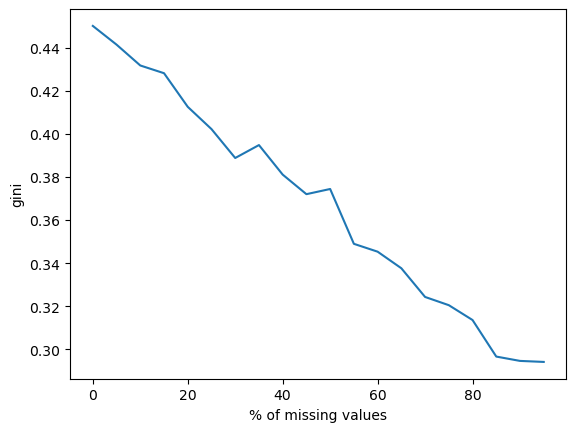

In [151]:
plt.plot(range(0, 100, 5), ginis_plt)
plt.ylabel('gini')
plt.xlabel('% of missing values')

Text(0.5, 0, '% of missing values')

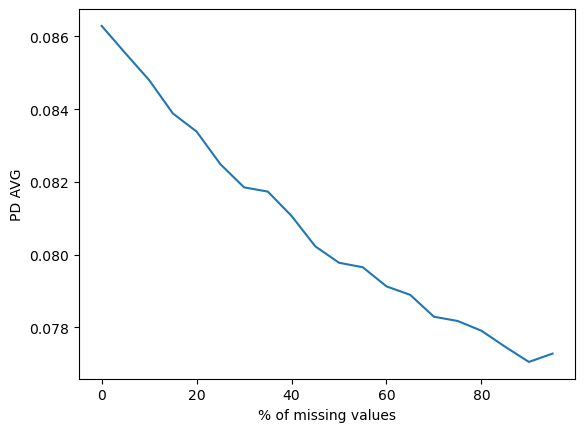

In [152]:
plt.plot(range(0, 100, 5), pd_avg)
plt.ylabel('PD AVG')
plt.xlabel('% of missing values')

Text(0.5, 0, '% of missing values')

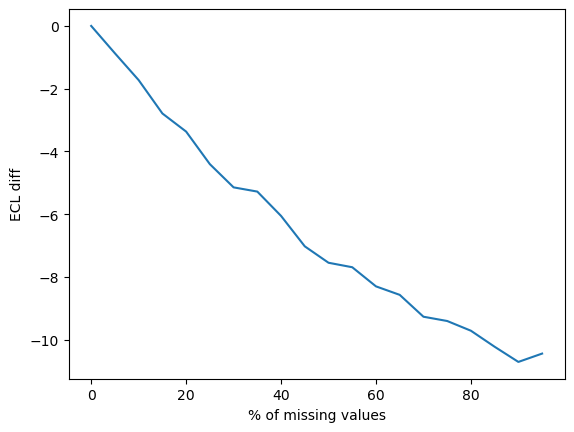

In [162]:
plt.plot(range(0, 100, 5), ecl_plt)
plt.ylabel('ECL diff')
plt.xlabel('% of missing values')

In [154]:
### График 4
train_px, test_px, train_py, test_py = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
model = LogisticRegression()
model = model.fit(train_px, train_py) #обучаем регрессию на нормальных данных
y_proba = model.predict_proba(test_px)
y_proba = y_proba[:, 1]
roc_auc = roc_auc_score(test_py, y_proba)
gini = 2*roc_auc - 1
loss = []
ginis_plt1 = []
for i in range(0, 100, 5): #доля пропусков от 0 до 100
    print(i)
    train_mm2 = train_mm1[l] #очищаем пропуски при корректировке доли пропусков
    loss.append(i)
    share = (i/100) * train_mm2.shape[0] #доля, выраженная числом элементов, которые будут заполнены пропусками
    share = int(share)
    for j in train_mm2.columns: #пропуски будут касаться каждого признака
        indexes_u = pd.Series()
        indexes = []
        while len(indexes) < share: #  !!  цикл для подбора уникального случайного значения индекса строки, куда подставится случайное значение
            indexes.append(random.choice(train_mm2.index))
            #indexes_u = pd.Series(indexes).unique()
        #indexes_u = indexes_u.tolist()
        mode = int(train_mm2[j].mode()[0])
        mean = train_mm2[j].mean()
        if train_mm2[j].dtype == 'bool':
            train_mm2[j].loc[indexes] = mode # !! так как нельзя вставить класс "nan", который напрямую говорит об отсутствии, представим, что сработал алгоритм по заполнению пропусков, заменяющий пропуски на моду'''
        else:
            train_mm2[j].loc[indexes] = mean
    train_p1x, test_p1x, train_p1y, test_p1y = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
    y1_proba = model.predict_proba(test_p1x) # на обученной ранее модели предсказываем вероятности
    y1_proba = y1_proba[:, 1]
    roc_auc1 = roc_auc_score(test_py, y1_proba)
    gini1 = 2*roc_auc1 - 1
    ginis_plt1.append(gini1)
train_mm2 = train_mm1[l]

0
5


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

10


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

15


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

20


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

25


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

30


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

35


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

40


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

45


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

50


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

55


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

60


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

65


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

70


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

75


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

80


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

85


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

90


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

95


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mean
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\3533899290.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = 

Text(0.5, 0, '% of missing values')

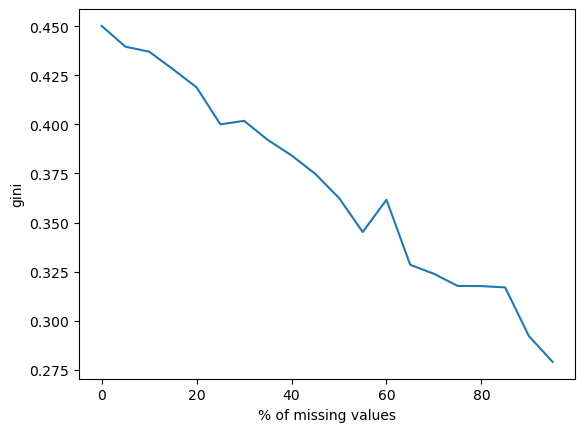

In [155]:
plt.plot(range(0, 100, 5), ginis_plt1)
plt.ylabel('gini')
plt.xlabel('% of missing values')

In [156]:
### Графики 5 и 6
''' тут отсечение означает дополнительное выделение в !тестовой! выборке одобренных заемщиков, неодобренные не удаляются, а просто не учитываются
'''
t_help = train_mm1[l].copy(deep=True) # для ресета пропусков
train_px, test_px, train_py, test_py = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
model = LogisticRegression()
model = model.fit(train_px, train_py)
loss = []
pd_avg = []
pd_nondef = []
dr_nonconf_plt = []
for i in range(0, 100, 5): 
    print(i)
    train_mm2 = t_help.copy(deep=True)
    loss.append(i)
    share = (i/100) * train_mm2.shape[0]
    share = int(share)
    for j in train_mm2.columns: 
        indexes_u = pd.Series()
        indexes = []
        while len(indexes) < share: 
            indexes.append(random.choice(train_mm2.index))
        mode = int(train_mm2[j].mode()[0])
        mean = train_mm2[j].mean()
        if train_mm2[j].dtype == 'bool':
            train_mm2[j].loc[indexes] = mode
            train_mm2[j].loc[indexes] = mean
    train_p1x, test_p1x, train_p1y, test_p1y = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
    y1_proba = model.predict_proba(test_p1x) # смотрим только на тестовую выборку!
    y1_proba = y1_proba[:, 1]
    y1 = pd.Series(y1_proba)
    y = y1_proba.mean()
    pd_avg.append(y) # PD AVG
    y2_proba = pd.Series(y1_proba)
    y2_proba = y2_proba[y2_proba <= 0.15] #формируем выборку из тех, у кого вероятность быть дефолтным меньше или равна 15%
    y2 = y2_proba.mean()
    pd_nondef.append(y2) # PD AVG для одобренных
    idx = y2_proba.index
    dr = target.loc[idx].value_counts(normalize=True)[1] #
    dr_nonconf_plt.append(dr)
train_mm2 = train_mm1[l]
print(loss, len(loss))
print(ginis_plt, len(ginis_plt))

0
5


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

10


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

15


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

20


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

25


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

30


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

35


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

40


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

45


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

50


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

55


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

60


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

65


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

70


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

75


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

80


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

85


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

90


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

95


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] 20
[0.4502096540677587, 0.4415119408625068, 0.4318289472196628, 0.42824012414826473, 0.41261855541002657, 0.40227253155191156, 0.38884638441962016, 0.39484984367411946, 0.38112835210575113, 0.3720353016166602, 0.3744446378725528, 0.34896809418519315, 0.34531885460689726, 0.33761121574324493, 0.3242835100981125, 0.32045998547633525, 0.3135632820829928, 0.29658087047735626, 0.294566705050302, 0.29409590372754124] 20


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\2811206472.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode


<function matplotlib.pyplot.show(close=None, block=None)>

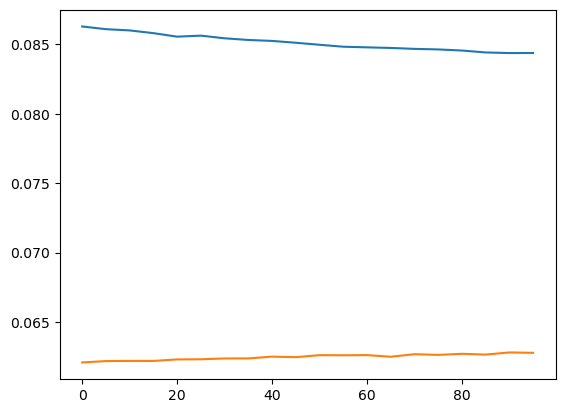

In [157]:
plt.plot(range(0, 100, 5), pd_avg)
plt.plot(range(0, 100, 5), pd_nondef)
plt.show

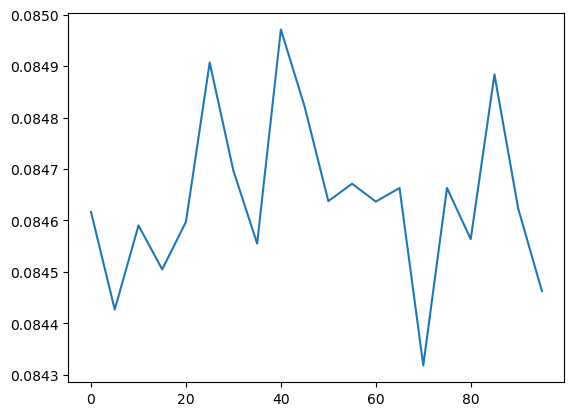

In [158]:
plt.plot(range(0, 100, 5), dr_nonconf_plt)

In [159]:
### Графики 5 и 6
''' тут отсечение означает удаление из !всей выборки! заемщиков, которым не был одобрен кредит
'''
t_help = train_mm1[l].copy(deep=True) # для ресета пропусков
train_px, test_px, train_py, test_py = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
model = LogisticRegression()
model = model.fit(train_px, train_py)
loss = []
pd_avg = []
pd_nondef = []
dr_nonconf_plt = []
for i in range(0, 100, 5): 
    print(i)
    train_mm2 = t_help.copy(deep=True)
    loss.append(i)
    share = (i/100) * train_mm2.shape[0]
    share = int(share)
    for j in train_mm2.columns: 
        indexes_u = pd.Series()
        indexes = []
        while len(indexes) < share: 
            indexes.append(random.choice(train_mm2.index))
        mode = int(train_mm2[j].mode()[0])
        mean = train_mm2[j].mean()
        if train_mm2[j].dtype == 'bool':
            train_mm2[j].loc[indexes] = mode
            train_mm2[j].loc[indexes] = mean
    train_p1x, test_p1x, train_p1y, test_p1y = train_test_split(train_mm2, target, test_size = 0.2, random_state = 2)
    y1_proba = model.predict_proba(train_mm2) #берем выборку целиком!
    y1_proba = y1_proba[:, 1]
    y = y1_proba.mean()
    pd_avg.append(y) # PD AVG
    y2_proba = pd.Series(y1_proba)
    y2_proba = y2_proba[y2_proba <= 0.15] # выборка из одобренных заемщиков
    idx = y2_proba.index
    y2 = y2_proba.mean()
    pd_nondef.append(y2)
    t_help = t_help.loc[idx] # чистим выборку от неодобренных
    t_help.reset_index(drop=True, inplace=True)
    target = target.loc[idx] # чистим таргет от неодобренных
    target.reset_index(drop=True, inplace=True)
    dr = target.value_counts(normalize=True)[1]
    dr_nonconf_plt.append(dr)
target = train_m['target']
train_mm1.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)
t_help = train_mm1[l].copy(deep=True)
train_mm2 = t_help
print(loss, len(loss))
print(ginis_plt, len(ginis_plt))

0


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

5


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

10


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

15


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

20


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

25


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

30


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

35


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

40


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

45


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

50


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

55


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

60


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

65


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

70


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

75


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

80


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

85


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

90


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

95


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\App

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] 20
[0.4502096540677587, 0.4415119408625068, 0.4318289472196628, 0.42824012414826473, 0.41261855541002657, 0.40227253155191156, 0.38884638441962016, 0.39484984367411946, 0.38112835210575113, 0.3720353016166602, 0.3744446378725528, 0.34896809418519315, 0.34531885460689726, 0.33761121574324493, 0.3242835100981125, 0.32045998547633525, 0.3135632820829928, 0.29658087047735626, 0.294566705050302, 0.29409590372754124] 20


C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mm2[j].loc[indexes] = mode
C:\Users\Максим\AppData\Local\Temp\ipykernel_93720\4272395450.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_mm2[j].loc[indexes] = mode


<function matplotlib.pyplot.show(close=None, block=None)>

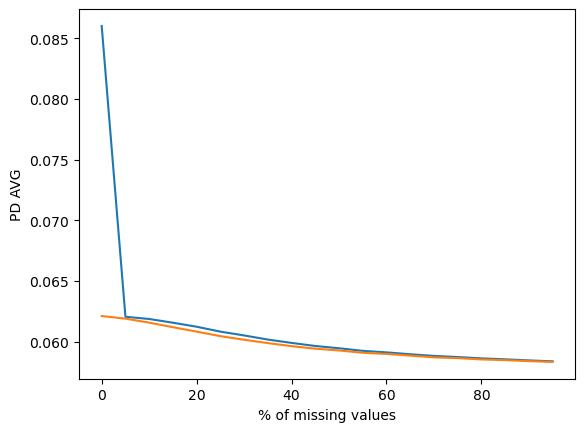

In [160]:
plt.plot(range(0, 100, 5), pd_avg, label = 'PD AVG')
plt.plot(range(0, 100, 5), pd_nondef, label = 'PD NONDEF AVG')
plt.ylabel('PD AVG')
plt.xlabel('% of missing values')
plt.show

Text(0.5, 0, '% of missing values')

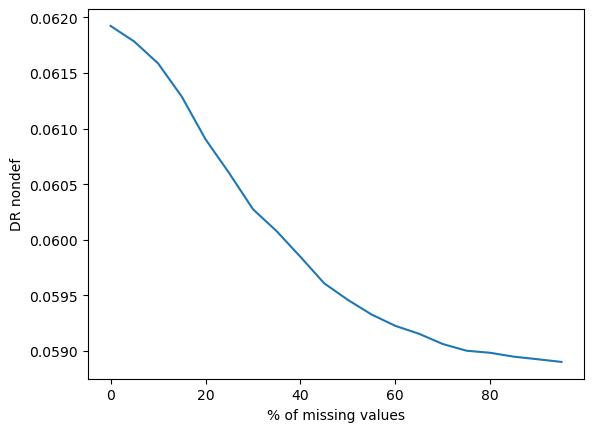

In [161]:
plt.plot(range(0, 100, 5), dr_nonconf_plt)
plt.ylabel('DR approved')
plt.xlabel('% of missing values')